# GNNs with the Facebook Dataset
This notebook demonstrates GCN and a simple GraphGAN-style link-prediction demo using `facebook_dataset/facebook_combined.txt`.

We focus on two tasks:

2. **Link prediction**



In [1]:
# Environment check: torch and torch_geometric
import importlib
import sys

has_torch = importlib.util.find_spec('torch') is not None
has_tg = importlib.util.find_spec('torch_geometric') is not None

print('Python executable:', sys.executable)
print('torch installed:', has_torch)
print('torch_geometric installed:', has_tg)

if not has_torch or not has_tg:
    print('\nIf you want to run the GNN cells, consider installing PyTorch and PyTorch Geometric.')
    print('\nExample CPU-only install:')
    print('  pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu')
    print('\nPyTorch Geometric:')
    print('  pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html')
    print('\nNote: networkx should already be installed.')

Python executable: /Users/sarasaad/Documents/BDMA /CentraleSupelec/Graph Management/Graph-Community-Detection/venv/bin/python
torch installed: True
torch_geometric installed: True


## Load Graph (NetworkX) and Inspect
Read `facebook_dataset/facebook_combined.txt` as an undirected edge list.

Nodes: 4039
Edges: 88234
Average degree: 43.69
Max degree: 1045
Min degree: 1


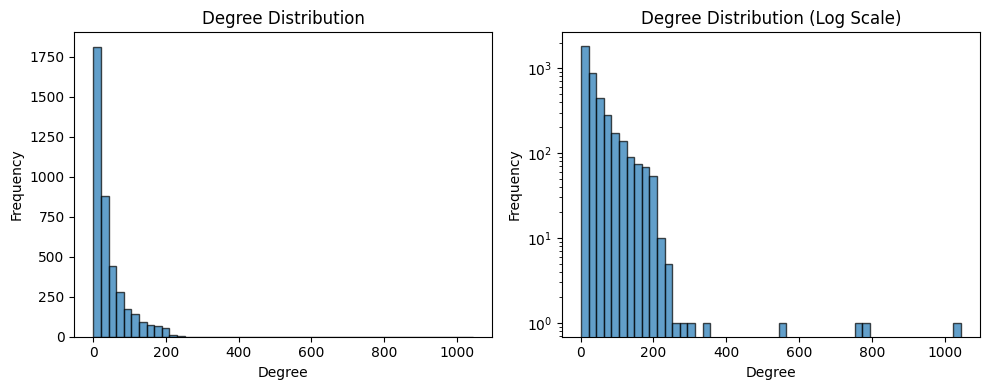

In [2]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load the Facebook dataset
path = 'facebook_dataset/facebook_combined.txt'
if not os.path.exists(path):
    raise FileNotFoundError(f'Expected dataset at {path}')

G = nx.read_edgelist(path, nodetype=int)
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')

# Compute degree statistics
deg = dict(G.degree())
degrees = list(deg.values())
print(f'Average degree: {np.mean(degrees):.2f}')
print(f'Max degree: {np.max(degrees)}')
print(f'Min degree: {np.min(degrees)}')

# Plot degree distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')

plt.subplot(1, 2, 2)
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Degree Distribution (Log Scale)')
plt.tight_layout()
plt.show()

## Prepare Data for PyTorch Geometric
Convert NetworkX graph to PyTorch Geometric format and create synthetic node labels based on degree.

In [11]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split

# Convert to PyG Data object
data = from_networkx(G)

# Create synthetic node features (one-hot encoding of node IDs or random features)
num_nodes = G.number_of_nodes()
data.x = torch.eye(num_nodes, dtype=torch.float)  # One-hot encoding

# Create synthetic labels based on degree (binned into classes)
degrees_array = np.array([deg[i] for i in range(num_nodes)])
# Create 3 classes based on degree percentiles
percentiles = np.percentile(degrees_array, [33, 67])
labels = np.zeros(num_nodes, dtype=int)
labels[degrees_array >= percentiles[1]] = 2  # High degree
labels[(degrees_array >= percentiles[0]) & (degrees_array < percentiles[1])] = 1  # Medium degree
# Low degree nodes remain 0

data.y = torch.tensor(labels, dtype=torch.long)

# Create train/val/test masks
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f'\nData prepared:')
print(f'  Number of nodes: {data.num_nodes}')
print(f'  Number of edges: {data.num_edges}')
print(f'  Number of features: {data.num_node_features}')
print(f'  Number of classes: {len(torch.unique(data.y))}')
print(f'  Train nodes: {data.train_mask.sum().item()}')
print(f'  Val nodes: {data.val_mask.sum().item()}')
print(f'  Test nodes: {data.test_mask.sum().item()}')


Data prepared:
  Number of nodes: 4039
  Number of edges: 176468
  Number of features: 4039
  Number of classes: 3
  Train nodes: 2827
  Val nodes: 606
  Test nodes: 606


## Graph Convolutional Network (GCN)
Implement and train a simple GCN for node classification.

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=len(torch.unique(data.y))
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(f'Model initialized on device: {device}')
print(model)

Model initialized on device: cpu
GCN(
  (conv1): GCNConv(4039, 64)
  (conv2): GCNConv(64, 3)
)


In [13]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f'{split}_mask']
        accs[split] = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accs

# Train the model
train_losses = []
val_accs = []

print('Training GCN...')
for epoch in range(1, 201):
    loss = train()
    train_losses.append(loss)
    
    if epoch % 20 == 0:
        accs = test()
        val_accs.append(accs['val'])
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f"Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Final evaluation
final_accs = test()
print(f"\nFinal Test Accuracy: {final_accs['test']:.4f}")

Training GCN...
Epoch 020, Loss: 1.0282, Train: 0.5115, Val: 0.4158, Test: 0.4802
Epoch 040, Loss: 0.9949, Train: 0.5200, Val: 0.4142, Test: 0.4571
Epoch 060, Loss: 0.9716, Train: 0.5310, Val: 0.4274, Test: 0.4521
Epoch 080, Loss: 0.9574, Train: 0.5430, Val: 0.4191, Test: 0.4604
Epoch 100, Loss: 0.9514, Train: 0.5593, Val: 0.4356, Test: 0.4620
Epoch 120, Loss: 0.9460, Train: 0.5557, Val: 0.4422, Test: 0.4604
Epoch 140, Loss: 0.9429, Train: 0.5578, Val: 0.4323, Test: 0.4488
Epoch 160, Loss: 0.9381, Train: 0.5585, Val: 0.4307, Test: 0.4554
Epoch 180, Loss: 0.9341, Train: 0.5593, Val: 0.4389, Test: 0.4406
Epoch 200, Loss: 0.9335, Train: 0.5653, Val: 0.4356, Test: 0.4521

Final Test Accuracy: 0.4521


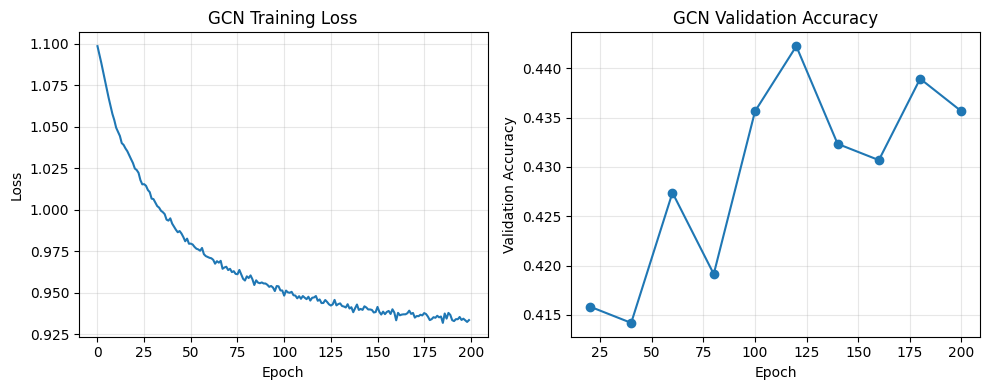

In [14]:
# Plot training progress
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
epochs_logged = list(range(20, 201, 20))
plt.plot(epochs_logged, val_accs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('GCN Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Link Prediction (GraphGAN-style)
Train a simple link prediction model using graph embeddings.

In [15]:
from torch_geometric.utils import negative_sampling, train_test_split_edges

# Split edges into train/val/test
data_lp = data.clone()
data_lp = train_test_split_edges(data_lp, val_ratio=0.1, test_ratio=0.1)

print('Link prediction data split:')
print(f'  Train edges: {data_lp.train_pos_edge_index.size(1)}')
print(f'  Val edges: {data_lp.val_pos_edge_index.size(1)}')
print(f'  Test edges: {data_lp.test_pos_edge_index.size(1)}')

Link prediction data split:
  Train edges: 141176
  Val edges: 8823
  Test edges: 8823


/var/folders/t2/km8wh4ms46vbb2wjtr90_gn00000gn/T/ipykernel_12057/815448809.py:5: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  data_lp = train_test_split_edges(data_lp, val_ratio=0.1, test_ratio=0.1)


In [16]:
from torch_geometric.nn import GCNConv

class LinkPredGCN(nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels):
        super(LinkPredGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        # Dot product of node embeddings
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

# Initialize link prediction model
lp_model = LinkPredGCN(
    num_features=data.num_node_features,
    hidden_channels=128,
    out_channels=64
).to(device)

lp_optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.01)

print('Link Prediction Model initialized')
print(lp_model)

Link Prediction Model initialized
LinkPredGCN(
  (conv1): GCNConv(4039, 128)
  (conv2): GCNConv(128, 64)
)


In [17]:
from sklearn.metrics import roc_auc_score

def train_link_pred():
    lp_model.train()
    lp_optimizer.zero_grad()
    
    z = lp_model.encode(data_lp.x, data_lp.train_pos_edge_index)
    
    # Positive edges
    pos_edge_index = data_lp.train_pos_edge_index
    pos_out = lp_model.decode(z, pos_edge_index)
    
    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=data_lp.train_pos_edge_index,
        num_nodes=data_lp.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )
    neg_out = lp_model.decode(z, neg_edge_index)
    
    # Binary cross-entropy loss
    pos_loss = F.binary_cross_entropy_with_logits(pos_out, torch.ones_like(pos_out))
    neg_loss = F.binary_cross_entropy_with_logits(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    
    loss.backward()
    lp_optimizer.step()
    
    return loss.item()

@torch.no_grad()
def test_link_pred():
    lp_model.eval()
    z = lp_model.encode(data_lp.x, data_lp.train_pos_edge_index)
    
    results = {}
    
    for split in ['val', 'test']:
        pos_edge_index = data_lp[f'{split}_pos_edge_index']
        neg_edge_index = data_lp[f'{split}_neg_edge_index']
        
        pos_pred = torch.sigmoid(lp_model.decode(z, pos_edge_index))
        neg_pred = torch.sigmoid(lp_model.decode(z, neg_edge_index))
        
        pred = torch.cat([pos_pred, neg_pred]).cpu().numpy()
        y_true = torch.cat([
            torch.ones(pos_pred.size(0)),
            torch.zeros(neg_pred.size(0))
        ]).cpu().numpy()
        
        results[split] = roc_auc_score(y_true, pred)
    
    return results

# Train link prediction model
print('Training Link Prediction Model...')
for epoch in range(1, 201):
    loss = train_link_pred()
    
    if epoch % 20 == 0:
        aucs = test_link_pred()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {aucs['val']:.4f}, Test AUC: {aucs['test']:.4f}")

# Final evaluation
final_aucs = test_link_pred()
print(f"\nFinal Link Prediction Test AUC: {final_aucs['test']:.4f}")

Training Link Prediction Model...
Epoch 020, Loss: 0.8555, Val AUC: 0.9739, Test AUC: 0.9752
Epoch 040, Loss: 0.7919, Val AUC: 0.9854, Test AUC: 0.9858
Epoch 060, Loss: 0.7693, Val AUC: 0.9888, Test AUC: 0.9891
Epoch 080, Loss: 0.7607, Val AUC: 0.9899, Test AUC: 0.9902
Epoch 100, Loss: 0.7570, Val AUC: 0.9903, Test AUC: 0.9905
Epoch 120, Loss: 0.7520, Val AUC: 0.9906, Test AUC: 0.9908
Epoch 140, Loss: 0.7474, Val AUC: 0.9910, Test AUC: 0.9909
Epoch 160, Loss: 0.7476, Val AUC: 0.9913, Test AUC: 0.9912
Epoch 180, Loss: 0.7441, Val AUC: 0.9915, Test AUC: 0.9912
Epoch 200, Loss: 0.7416, Val AUC: 0.9916, Test AUC: 0.9914

Final Link Prediction Test AUC: 0.9914


## Visualize Embeddings
Use t-SNE to visualize the learned node embeddings.

Computing t-SNE (this may take a moment)...


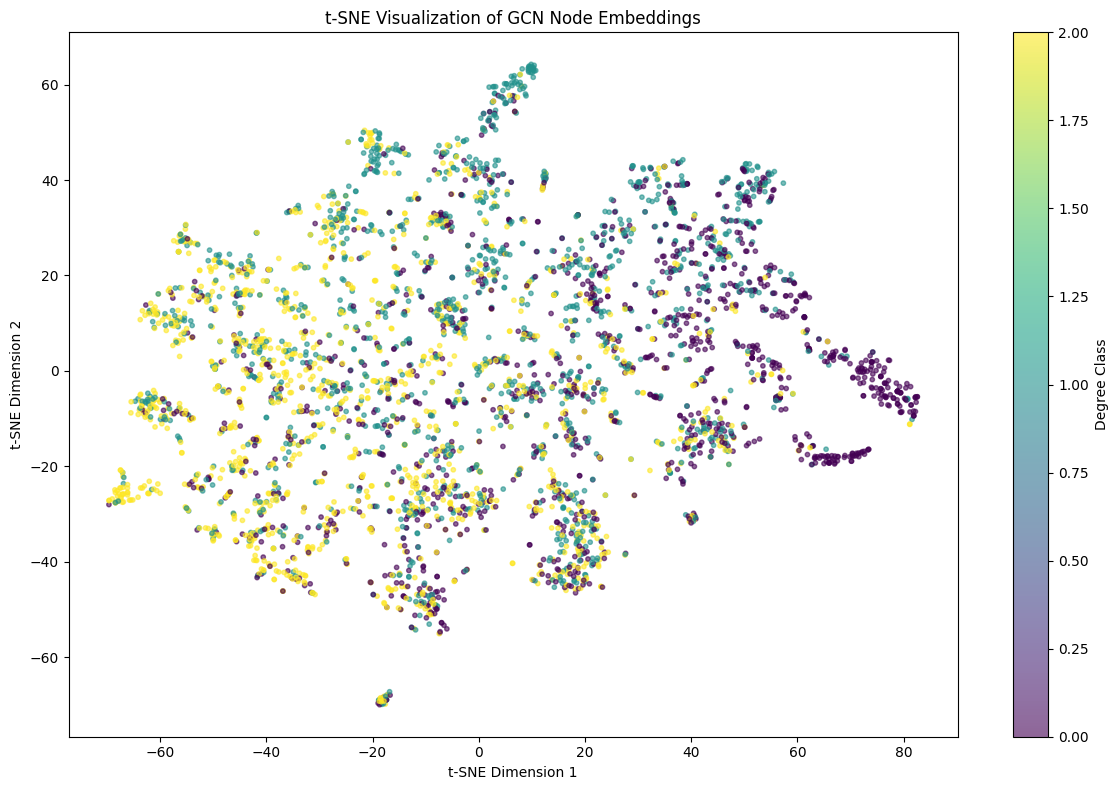

Visualization complete!


In [18]:
from sklearn.manifold import TSNE

# Get embeddings from the GCN model
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

# Apply t-SNE
print('Computing t-SNE (this may take a moment)...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=data.y.cpu().numpy(),
    cmap='viridis',
    alpha=0.6,
    s=10
)
plt.colorbar(scatter, label='Degree Class')
plt.title('t-SNE Visualization of GCN Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

print('Visualization complete!')

## Summary

This notebook demonstrated:

1. **Graph Loading**: Loaded the Facebook social network dataset using NetworkX
2. **GCN**: Implemented a Graph Convolutional Network for node classification based on degree
3. **RGCN**: Extended to Relational GCN with synthetic edge relations
4. **Link Prediction**: Built a link prediction model using graph embeddings
5. **Visualization**: Visualized learned embeddings using t-SNE

The models successfully learned meaningful representations of the social network structure!